##### The purpose of this notebook is to demonstrate the use of custom callbacks, validation only on `u_out==0`, custom discretization (with extrapolation) and some new features.

##### Many thanks to [Chris Deotte](https://www.kaggle.com/cdeotte), [DLastStark](https://www.kaggle.com/dlaststark), [Zhangxin](https://www.kaggle.com/tenffe), [Niwashi](https://www.kaggle.com/marutama), [Carl McBride Ellis](https://www.kaggle.com/carlmcbrideellis) and many others for their ideas, discussions, models, features, etc.

# Imports

In [1]:
import math
import os
from pathlib import Path
import random
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import *

import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras import mixed_precision

In [2]:
tf.__version__

'2.4.1'

# Constants

In [3]:
BATCH_SIZE = 64
EPOCHS = 300
FOLD_NUM = 5 # Total number of folds
FOLDS = [0] # List of folds to run
SEED = 23

DEBUG = False

# TPU Config

In [4]:
# Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()
    
    print("REPLICAS: ", strategy.num_replicas_in_sync)
    return tpu, strategy

tpu, strategy = get_hardware_strategy()

REPLICAS:  1


In [5]:
REPLICAS = strategy.num_replicas_in_sync
if tpu:
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE
else:
    BATCH_SIZE = 8 * BATCH_SIZE
print('BATCH_SIZE:', BATCH_SIZE)

BATCH_SIZE: 512


# Output files

In [6]:
MODELS = Path("models")
MODELS.mkdir(exist_ok=True)

PREDS = Path("preds")
PREDS.mkdir(exist_ok=True)

HISTORY = Path("history")
HISTORY.mkdir(exist_ok=True)

INDICES = Path("indices")
INDICES.mkdir(exist_ok=True)

# Seeding

In [7]:
def set_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(SEED)

# Read data

In [8]:
train_df = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/train.csv")
test_df = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv")

pressure_values = np.array(sorted(train_df["pressure"].unique().tolist()))

if DEBUG:
    train_df = train_df[:80*10000]
    test_df = test_df[:80*10000]

sub = test_df[["id"]]    
    
pressure_values.shape

(950,)

# Features

In [9]:
def generate_shift(df, columns, windows):
    for col in columns:
        for window in windows:    
            df[col + '_shift_pos_' + str(window)] = df.groupby('breath_id')[col].shift(window)
            df[col + '_shift_neg_' + str(window)] = df.groupby('breath_id')[col].shift(-1 * window)
            df[col + '_shift_diff_pos_' + str(window)] = df[col] - df[col + '_shift_pos_' + str(window)]
            df[col + '_shift_diff_neg_' + str(window)] = df[col] - df[col + '_shift_neg_' + str(window)]
            df.fillna(0, inplace=True)
    return df

In [10]:
def generate_rolling(df, columns, windows):
    for col in columns:
        for window in windows:    
            df[col + '_rolling_mean_' + str(window)] = df.groupby('breath_id')[col].rolling(window).mean().reset_index(drop=True)
            df[col + '_rolling_min_' + str(window)] = df.groupby('breath_id')[col].rolling(window).min().reset_index(drop=True)
            df[col + '_rolling_max_' + str(window)] = df.groupby('breath_id')[col].rolling(window).max().reset_index(drop=True)
            df[col + '_rolling_std_' + str(window)] = df.groupby('breath_id')[col].rolling(window).std().reset_index(drop=True)
    return df

In [11]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    cols = ['u_in']
    windows = [1, 2, 4]
    df = generate_shift(df, cols, windows)
    print("Step-2...Completed")
    
    windows = [8, 16]
    df = generate_shift(df, cols, windows)
    print("Step-3...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] = df['u_in_cumsum'] /df['count']
    df.drop(['one', 'count'], axis=1, inplace=True)
    
    df['breath_id_lag'] = df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2'] = df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame'] = np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same'] = np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    df.drop(['breath_id_lag', 'breath_id_lag2', 'breath_id_lagsame', 'breath_id_lag2same'], axis=1, inplace=True)
    print("Step-5...Completed")

    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    print("Step-6...Completed")
        
    df['time_gap'] = df['time_step'] - df.shift(1).fillna(0)['time_step']
    df['u_in_rate'] = df['u_in_shift_pos_1'] / df['time_gap']

    df.loc[list(range(0, len(df), 80)), 'time_gap'] = 0
    df.loc[list(range(0, len(df), 80)), 'u_in_rate'] = 0
    
    df['area_1'] = df['u_in'] * df['time_gap']
    df['area_cumsum_1'] = (df['area_1']).groupby(df['breath_id']).cumsum()
    
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    
    print("Step-7...Completed")
    
    df['u_in_2'] = df['u_in'] ** 2
    df['u_in_3'] = df['u_in'] ** 3
    df['R_2'] = df['R'] ** 2
    df['C_2'] = df['C'] ** 2

    df['R_2__mul__u_in_2'] = df['R_2'] * df['u_in_2']
    df['C_2__div__R_2'] = df['C_2'] / df['R_2']
    df['R__mul__u_in_2'] = df['R'] * df['u_in_2']
    df['C__div__u_in_2'] = df['C'] / df['u_in_2']
    df['C_2__div__u_in_2'] = df['C_2'] / df['u_in_2']
    df['R_2__div__u_in_2'] = df['R_2'] / df['u_in_2']
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    df = pd.get_dummies(df)
    print("Step-8...Completed")

    gc.collect()
    return df

In [12]:
%%time
preprocessed_train_df = add_features(train_df)
del train_df
gc.collect()

preprocessed_test_df = add_features(test_df)
del test_df
gc.collect()

preprocessed_train_df.shape, preprocessed_test_df.shape

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed
Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed
CPU times: user 2min 39s, sys: 26.7 s, total: 3min 6s
Wall time: 3min 2s


((6036000, 65), (4024000, 64))

In [13]:
u_out_0 = preprocessed_train_df['u_out'].to_numpy().reshape(-1, 80)
test_indices = preprocessed_test_df.index

In [14]:
targets = preprocessed_train_df[['pressure']].to_numpy().reshape(-1, 80)

to_drop = ['id', 'breath_id']
train = preprocessed_train_df.drop(['pressure'] + to_drop, axis=1)
test = preprocessed_test_df.drop(to_drop, axis=1)

del preprocessed_train_df
del preprocessed_test_df
gc.collect()

targets.shape

(75450, 80)

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1197.33 Mb (52.0% reduction)
Mem. usage decreased to 798.22 Mb (52.0% reduction)


In [17]:
scaler = RobustScaler(copy=False)
train = scaler.fit_transform(train)
test = scaler.transform(test)

del scaler
gc.collect()

21

In [18]:
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

train.shape, test.shape

((75450, 80, 62), (50300, 80, 62))

# Model

In [19]:
def build_model(*metrics):

    input_shape = train.shape[-2:]
    x_input = Input(shape=input_shape)

    x1 = Bidirectional(LSTM(units=512, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=256, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=64, return_sequences=True))(x3)
    
    z2 = Bidirectional(GRU(units=128, return_sequences=True))(x2)
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z3 = Bidirectional(GRU(units=64, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z4 = Bidirectional(GRU(units=32, return_sequences=True))(z41)
        
    x = Concatenate(axis=2)([x4, z2, z3, z4])
    
    x = Dense(units=128, activation='selu')(x)

    x_output = Dense(units=1)(x)
    
    model = Model(inputs=x_input, outputs=x_output)
        
    opt = Adam(learning_rate=1e-3)
    
    loss = MeanAbsoluteError()
    model.compile(optimizer=opt, loss=loss, metrics=list(metrics))

    return model

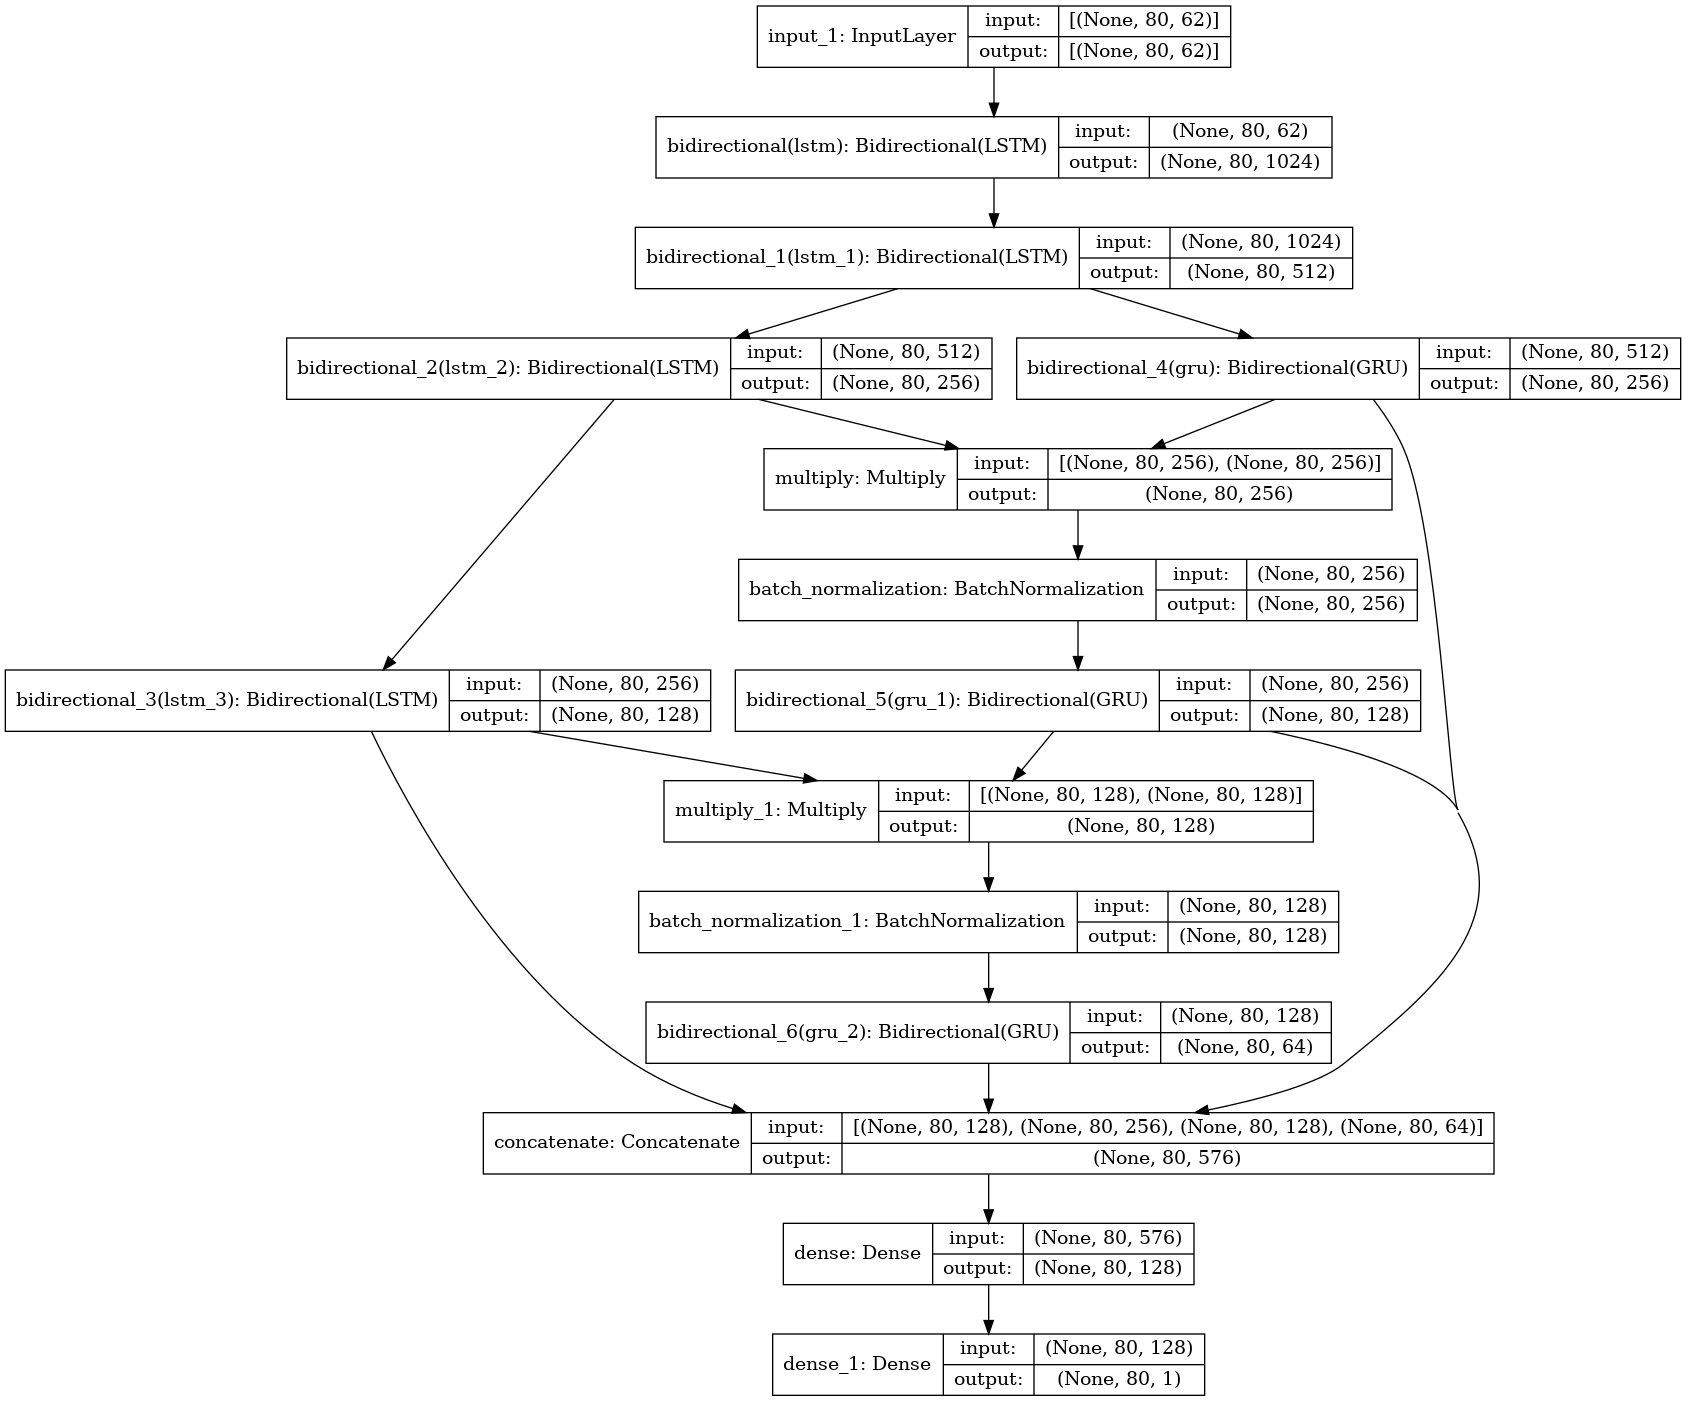

In [20]:
model = build_model()
plot_model(model, to_file='ventilator_keras_model.png', show_shapes=True, show_layer_names=True)

In [21]:
del model
gc.collect()

57656

# Discretization

In [22]:
diff = np.diff(pressure_values)
step = np.median(diff)
step

0.07030214545121538

In [23]:
EXTRAPOLATE_KNOTS = 100

left_pressure_extrapolate = np.arange(pressure_values[0] - EXTRAPOLATE_KNOTS* step, pressure_values[0] - step, step)
right_pressure_extrapolate = np.arange(pressure_values[-1] + step, pressure_values[-1] + EXTRAPOLATE_KNOTS* step, step)

pressure_values_extra = np.concatenate([left_pressure_extrapolate, pressure_values, right_pressure_extrapolate])
pressure_values_extra.shape

pressure_values_extra_mid_points = (pressure_values_extra[1:] + pressure_values_extra[:-1]) / 2
pressure_values_extra_mid_points.shape

del diff
del left_pressure_extrapolate
del right_pressure_extrapolate
del pressure_values
gc.collect()

42

In [24]:
def discretize_np(y_discr, y_midpoints, y_cont):
    indices = np.searchsorted(y_midpoints, y_cont, side="left")
    result = y_discr[indices]
    return result

# Early Stopping

In [25]:
class EarlyStoppingAtMinMAE(Callback):

    def __init__(self, model, inputs, targets, indices, epochs, patience=0, fold=0):
        super(EarlyStoppingAtMinMAE, self).__init__()

        self.model = model
        self.inputs = inputs
        self.targets = targets
        self.indices = indices
        self.patience = patience
        self.fold = fold

        self.best_weights = None
        self.last_epoch = epochs - 1

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict(self.inputs)
        pred_flat = pred.ravel()
        pred_flat_discrete = discretize_np(pressure_values_extra, pressure_values_extra_mid_points, pred_flat)

        current_score = mean_absolute_error(self.targets[self.indices], pred_flat[self.indices])
        current_score_discrete = mean_absolute_error(self.targets[self.indices], pred_flat_discrete[self.indices])
#         current_score_all = mean_absolute_error(self.targets, pred_flat)
#         current_score_all_discrete = mean_absolute_error(self.targets, pred_flat_discrete)
        print(f'MAE score (discrete, u_out==0): {current_score_discrete:.6f}, MAE score (non-discrete, u_out==0): {current_score:.6f}\n')
#         print(f'MAE score (discrete, all indices): {current_score_all_discrete:.4f}, MAE score (non-discrete, all indices): {current_score_all:.4f}, \n')

        if np.less(current_score_discrete, self.best):
            self.best = current_score_discrete
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)
        if epoch == self.last_epoch:
            self.model.set_weights(self.best_weights)
            
        del pred
        del pred_flat
        del pred_flat_discrete
        gc.collect()

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f'Epoch {self.stopped_epoch + 1}: early stopping. Best MAE: {self.best:.6f}')
        self.model.save_weights(f"{MODELS}/fold_{self.fold}.h5")

# Training

In [26]:
k_fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

oof_preds = []
oof_preds_discrete = []
oof_targets = []

test_preds = []
test_preds_discrete = []
for fold, (train_idx, val_idx) in enumerate(k_fold.split(train, targets)):
    if fold not in FOLDS: continue
    
    K.clear_session()
        
    print(f"FOLD={fold} started")
    
    np.save(INDICES / f"train_{fold}", train_idx)
    np.save(INDICES / f"val_{fold}", val_idx)

    X_train, X_val = train[train_idx], train[val_idx]
    y_train, y_val = targets[train_idx], targets[val_idx]
    
    u_out_0_val = u_out_0[val_idx]    
    u_out_0_val_flat = u_out_0_val.ravel()
    u_out_0_val_flat = list(map(bool, u_out_0_val_flat))
    u_out_0_val_flat = ~np.array(u_out_0_val_flat)
    
    y_val_flat = y_val.ravel()

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, patience=10, verbose=1)
    
    with strategy.scope():
        model = build_model()
    
#     es = EarlyStopping(monitor='val_loss',mode='min', patience=100, verbose=1, restore_best_weights=True)
    es = EarlyStoppingAtMinMAE(model, X_val, y_val_flat, u_out_0_val_flat, EPOCHS, patience=75, fold=fold)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es, lr])
    
    print(f"FOLD={fold} started train prediction")
    train_pred = model.predict(X_train).ravel()
    np.save(PREDS / f"train_pred_fold_{fold}", train_pred)
    train_pred_discrete = discretize_np(pressure_values_extra, pressure_values_extra_mid_points, train_pred)
    np.save(PREDS / f"train_pred_fold_{fold}_discrete", train_pred_discrete)
    del train_pred
    del train_pred_discrete
    
    print(f"FOLD={fold} started validation prediction")
    val_pred = model.predict(X_val).ravel()
    np.save(PREDS / f"val_pred_fold_{fold}", val_pred)
    oof_preds.append(val_pred[u_out_0_val_flat].tolist())
    val_pred_discrete = discretize_np(pressure_values_extra, pressure_values_extra_mid_points, val_pred)
    np.save(PREDS / f"val_pred_fold_{fold}_discrete", val_pred_discrete)
    oof_preds_discrete.append(val_pred_discrete[u_out_0_val_flat])
    oof_targets.append(y_val_flat[u_out_0_val_flat])
    val_mae = mean_absolute_error(y_val_flat[u_out_0_val_flat], val_pred[u_out_0_val_flat])
    val_mae_discrete = mean_absolute_error(y_val_flat[u_out_0_val_flat], val_pred_discrete[u_out_0_val_flat])
    print(f"FOLD={fold} | MAE score (discrete, u_out==0): {val_mae_discrete:.6f},  MAE score (non-discrete, u_out==0): {val_mae:.6f}")
    del val_pred
    del val_pred_discrete

    print(f"FOLD={fold} started test prediction")
    test_pred = model.predict(test).ravel()
    np.save(PREDS / f"test_pred_fold_{fold}", test_pred)
    test_preds.append(test_pred)
    test_pred_discrete = discretize_np(pressure_values_extra, pressure_values_extra_mid_points, test_pred)
    np.save(PREDS / f"test_pred_fold_{fold}_discrete", test_pred_discrete)
    test_preds_discrete.append(test_pred_discrete)
    del test_pred
    del test_pred_discrete
    
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(HISTORY / f"history_{fold}.csv", index=False)
    del history_df
    
    del X_train
    del X_val
    del y_train
    del y_val
    del u_out_0_val  
    del u_out_0_val_flat
    del y_val_flat
    gc.collect()

    print(f"FOLD={fold} finished")

FOLD=0 started
Epoch 1/300
118/118 [==============================] - 76s 458ms/step - loss: 2.5928 - val_loss: 2.2876
MAE score (discrete, u_out==0): 2.442648, MAE score (non-discrete, u_out==0): 2.442693

Epoch 2/300
118/118 [==============================] - 49s 418ms/step - loss: 0.7337 - val_loss: 1.4662
MAE score (discrete, u_out==0): 1.848006, MAE score (non-discrete, u_out==0): 1.848068

Epoch 3/300
118/118 [==============================] - 49s 418ms/step - loss: 0.5648 - val_loss: 0.9866
MAE score (discrete, u_out==0): 1.407002, MAE score (non-discrete, u_out==0): 1.407211

Epoch 4/300
118/118 [==============================] - 49s 419ms/step - loss: 0.5089 - val_loss: 0.6024
MAE score (discrete, u_out==0): 0.964251, MAE score (non-discrete, u_out==0): 0.964373

Epoch 5/300
118/118 [==============================] - 49s 419ms/step - loss: 0.4748 - val_loss: 0.5423
MAE score (discrete, u_out==0): 0.722595, MAE score (non-discrete, u_out==0): 0.722796

Epoch 6/300
118/118 [====

In [27]:
oof_preds = np.hstack(oof_preds)
oof_preds_discrete = np.hstack(oof_preds_discrete)
oof_targets = np.hstack(oof_targets)

oof_mae = mean_absolute_error(oof_targets, oof_preds)
oof_mae_discrete = mean_absolute_error(oof_targets, oof_preds_discrete)
print(f"OOF | MAE score (discrete, u_out==0): {oof_mae_discrete:.6f},  MAE score (non-discrete, u_out==0): {oof_mae:.6f}")

OOF | MAE score (discrete, u_out==0): 0.194914,  MAE score (non-discrete, u_out==0): 0.196192


In [28]:
sub['pressure'] = 0

# ENSEMBLE FOLDS WITH MEAN
sub.loc[test_indices, 'pressure'] = sum(test_preds) / len(test_preds)
sub[["id", "pressure"]].to_csv("submission_mean.csv", index=False)

# ENSEMBLE FOLDS WITH MEDIAN
sub.loc[test_indices, 'pressure'] = np.median(np.vstack(test_preds),axis=0)
sub[["id", "pressure"]].to_csv("submission_median.csv", index=False)
sub[["id", "pressure"]]

,id,pressure
0,1,6.306860
1,2,5.951009
2,3,7.081218
3,4,7.526865
4,5,9.063958
...,...,...
4023995,4023996,6.077566
4023996,4023997,6.226757
4023997,4023998,6.325960
4023998,4023999,6.068257


In [29]:
del test_preds

In [30]:
# ENSEMBLE FOLDS WITH MEAN
sub.loc[test_indices, 'pressure'] = sum(test_preds_discrete) / len(test_preds_discrete)
sub[["id", "pressure"]].to_csv("submission_mean_discrete.csv", index=False)

# ENSEMBLE FOLDS WITH MEDIAN
sub.loc[test_indices, 'pressure'] = np.median(np.vstack(test_preds_discrete),axis=0)
sub[["id", "pressure"]].to_csv("submission_median_discrete.csv", index=False)
sub[["id", "pressure"]]

,id,pressure
0,1,6.329607
1,2,5.978096
2,3,7.102930
3,4,7.524743
4,5,9.071390
...,...,...
4023995,4023996,6.048398
4023996,4023997,6.259305
4023997,4023998,6.329607
4023998,4023999,6.048398
